In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.utils.mobile_optimizer import optimize_for_mobile

## Load Data

In [2]:
def loadData():
    #dirPath = os.getcwd()
    dirPath = '/kaggle/input/logger-data'
    acce_columns = ['time', 'acce_x', 'acce_y', 'acce_z']
    gyro_columns = ['time', 'gyro_x', 'gyro_y', 'gyro_z']
    
    allData = list()
    
    for dataDir in os.listdir(dirPath + "/allData"):
        path = dirPath + "/allData/" + dataDir + "/"
        if (dataDir.split('_'))[1] == "walk":
            lable = 1
        else:
            lable = 0
        
        df_acce = pd.read_csv(path+"acce.txt", skiprows=1, names=acce_columns, sep='\s+')
        df_acce = df_acce.drop("time", axis=1)
        df_gyro = pd.read_csv(path+"gyro.txt", skiprows=1, names=gyro_columns, sep='\s+')
        df_gyro = df_gyro.drop("time", axis=1)

        df_new = pd.concat([df_acce, df_gyro], axis=1)
        df_new["label"] = lable
        allData.append(df_new)
    
    return pd.concat(allData, ignore_index=True)

In [3]:
def loadTrain():
    #dirPath = os.getcwd()
    dirPath = '/kaggle/input/logger-data-v2'
    acce_columns = ['time', 'acce_x', 'acce_y', 'acce_z']
    gyro_columns = ['time', 'gyro_x', 'gyro_y', 'gyro_z']
    
    allData = list()
    
    for dataDir in os.listdir(dirPath + "/train"):
        path = dirPath + "/train/" + dataDir + "/"
        if (dataDir.split('_'))[1] == "walk":
            lable = 1
        else:
            lable = 0
        
        df_acce = pd.read_csv(path+"acce.txt", skiprows=1, names=acce_columns, sep='\s+')
        df_acce = df_acce.drop("time", axis=1)
        df_gyro = pd.read_csv(path+"gyro.txt", skiprows=1, names=gyro_columns, sep='\s+')
        df_gyro = df_gyro.drop("time", axis=1)

        df_new = pd.concat([df_acce, df_gyro], axis=1)
        df_new["label"] = lable
        allData.append(df_new)
    
    return pd.concat(allData, ignore_index=True)


def loadTest():
    #dirPath = os.getcwd()
    dirPath = '/kaggle/input/logger-data-v2'
    acce_columns = ['time', 'acce_x', 'acce_y', 'acce_z']
    gyro_columns = ['time', 'gyro_x', 'gyro_y', 'gyro_z']
    
    allData = list()
    
    for dataDir in os.listdir(dirPath + "/test"):
        path = dirPath + "/test/" + dataDir + "/"
        if (dataDir.split('_'))[1] == "walk":
            lable = 1
        else:
            lable = 0
        
        df_acce = pd.read_csv(path+"acce.txt", skiprows=1, names=acce_columns, sep='\s+')
        df_acce = df_acce.drop("time", axis=1)
        df_gyro = pd.read_csv(path+"gyro.txt", skiprows=1, names=gyro_columns, sep='\s+')
        df_gyro = df_gyro.drop("time", axis=1)

        df_new = pd.concat([df_acce, df_gyro], axis=1)
        df_new["label"] = lable
        allData.append(df_new)
    
    return pd.concat(allData, ignore_index=True)

In [4]:
def create_sequences(data, labels, seq_length):
    xs = []
    ys = []
    for i in range(0, len(data) - seq_length, seq_length//2):
        x = data[i:i+seq_length]
        y = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), 'checkpoint.pt')

In [6]:
'''
data = loadData()

data.fillna(data.mean(), inplace=True)
X = data.drop(columns=['label'])

y = data['label']
scaler = StandardScaler()
X = scaler.fit_transform(X)

sequence_length = 50
X_sequences, y_sequences = create_sequences(X, y, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
'''

"\ndata = loadData()\n\ndata.fillna(data.mean(), inplace=True)\nX = data.drop(columns=['label'])\n\ny = data['label']\nscaler = StandardScaler()\nX = scaler.fit_transform(X)\n\nsequence_length = 50\nX_sequences, y_sequences = create_sequences(X, y, sequence_length)\n\nX_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)\n"

In [7]:
data_train = loadTrain()
data_test = loadTest()

data_train.fillna(data_train.mean(), inplace=True)
data_test.fillna(data_test.mean(), inplace=True)

X_train = data_train.drop(columns=['label'])
X_test = data_test.drop(columns=['label'])

y_train = data_train['label']
y_test = data_test['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mean_values = scaler.mean_
std_values = np.sqrt(scaler.var_)

np.savetxt("mean_values.txt", mean_values)
np.savetxt("std_values.txt", std_values)

sequence_length = 20
X_train, y_train = create_sequences(X_train, y_train, sequence_length)
X_test, y_test = create_sequences(X_test, y_test, sequence_length)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
X_test_tensor.shape

torch.Size([5569, 20, 6])

In [10]:
batch_size = 64

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

## Create Model

In [11]:
class WalkDetectionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(WalkDetectionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.7)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

## Train

In [12]:
input_size = X_train.shape[2]
hidden_size = 64
output_size = 1
num_layers = 2

In [13]:
device = torch.device('cpu')

In [14]:
model = WalkDetectionRNN(input_size, hidden_size, output_size, num_layers).to(device)

In [15]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [16]:
num_epochs = 20
losses = []

early_stopping = EarlyStopping(patience=5, delta=0.001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        predicted = (test_outputs.squeeze() > 0.5).float()
        accuracy = (predicted == y_test_tensor).float().mean()
        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test Loss: {test_loss.item():.4f}')
    
    
    early_stopping(test_loss.item(), model)
    if early_stopping.early_stop:
        num_epochs=epoch+1
        print("Early stopping")
        break

Epoch 1/20, Loss: 0.5549777764236549
Test Accuracy: 0.9131
Test Loss: 0.3389
Epoch 2/20, Loss: 0.38696816061175177
Test Accuracy: 0.9384
Test Loss: 0.2321
Epoch 3/20, Loss: 0.31031373061604733
Test Accuracy: 0.9609
Test Loss: 0.1674
Epoch 4/20, Loss: 0.24201352838480508
Test Accuracy: 0.9639
Test Loss: 0.1356
Epoch 5/20, Loss: 0.17274445983492676
Test Accuracy: 0.9704
Test Loss: 0.1021
Epoch 6/20, Loss: 0.13685301890977866
Test Accuracy: 0.9670
Test Loss: 0.1054
Epoch 7/20, Loss: 0.12553890460635125
Test Accuracy: 0.9756
Test Loss: 0.0802
Epoch 8/20, Loss: 0.11776505732205657
Test Accuracy: 0.9695
Test Loss: 0.1009
Epoch 9/20, Loss: 0.11210397087703178
Test Accuracy: 0.9677
Test Loss: 0.0997
Epoch 10/20, Loss: 0.1067036489583015
Test Accuracy: 0.9711
Test Loss: 0.0872
Epoch 11/20, Loss: 0.10396757408955083
Test Accuracy: 0.9747
Test Loss: 0.0774
Epoch 12/20, Loss: 0.10241669967706163
Test Accuracy: 0.9741
Test Loss: 0.0762
Epoch 13/20, Loss: 0.09873514561793131
Test Accuracy: 0.9714
Te

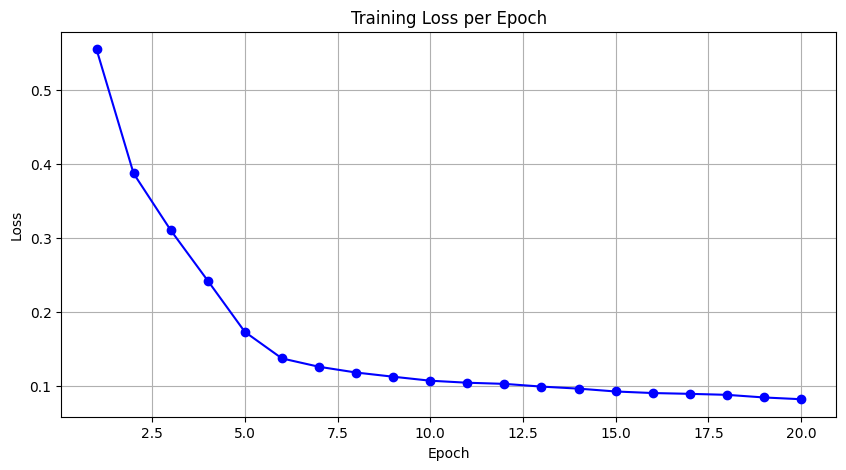

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

## Test

In [18]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    predicted = (test_outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Loss: {test_loss.item():.4f}')

Test Accuracy: 0.9706
Test Loss: 0.0812


## Save model

In [19]:
traced_script_module = torch.jit.trace(model, X_test_tensor[:8])
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("model_rnn_v2.pt")